In [2]:
import scipy.io as scio
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from module.eguNetSS import eguNetss
from module.unmixing import sunsal, vca
from module.utils import getPatches, getImageFromPatches

# Data import

In [ ]:
mat = scio.loadmat('./data/50x128x128.mat')

A = mat['A'] # r, p
wavelengths = mat['wavelengths'][0] # r
mineral_names = mat['mineral_names'] # r
Y_list = mat['Y'] # height, width, r
# Y_GT_list = mat['Y_GT'] # height, width, r
X_list = mat['X'] # height, width, p
del mat

samples, height, width, p = X_list.shape
N = height * width # number of pixels
r = len(wavelengths) # number of wavelengths

k_test = np.random.randint(len(X_list)) #index of the X that will be used as validation / whole image

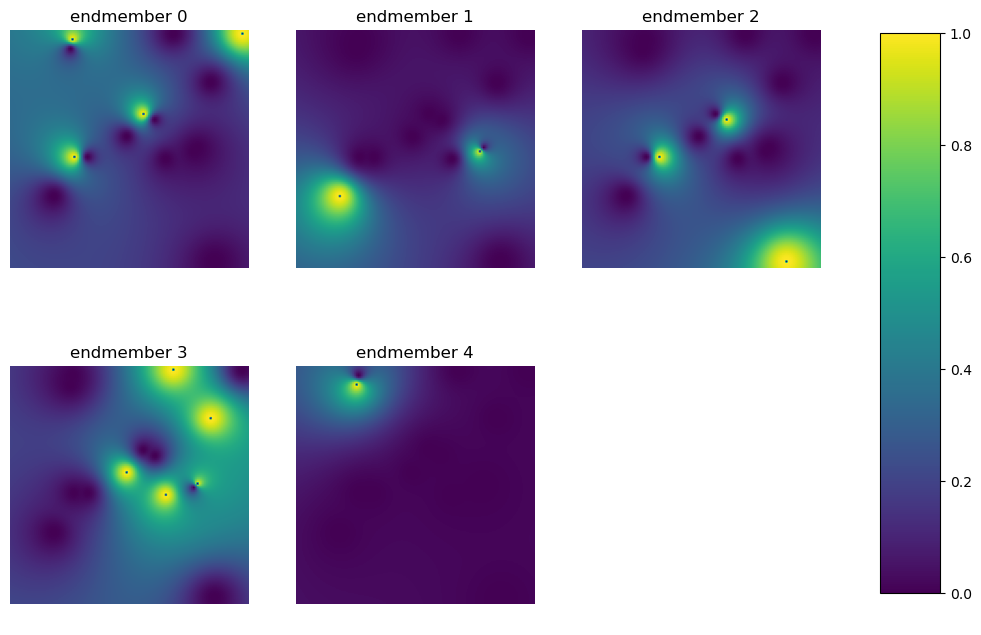

In [175]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

for k in range(np.prod(axes.shape)):
    ax = axes.flat[k]
    ax.axis("off")
    ax.get_yaxis().set_visible(False)
    if k >= p:
        continue
    ax.set_title(f"endmember {k}")
    im = ax.imshow(X_list[k_test,:,:,k], vmin=0, vmax=1)

fig.subplots_adjust(right=0.8) 
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

# Multiple HSIs Strategy

## Pre-process

c:\Users\arthu\anaconda3\envs\troisneuf\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\arthu\anaconda3\envs\troisneuf\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\arthu\anaconda3\envs\troisneuf\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\arthu\anaconda3\envs\troisneuf\lib\site-packages\sklearn\cluster\_kmeans.py:1429: 

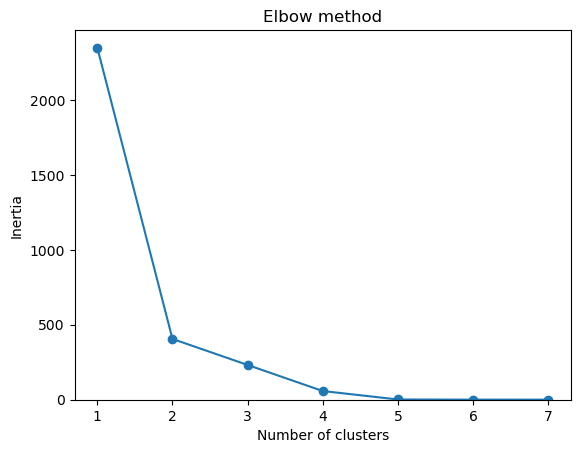

In [176]:
# Extraction of the endmembers spectra with VCA algorithm
endmembers_list = np.zeros((samples, p, r))
for k in range(len(Y_list)):
    Y = Y_list[k]
    endmembers_list[k] = vca(Y.reshape(-1, r).T, p, verbose=False)[0].T
    
# Finding the best number of clusters with the elbow method
inertia = []

max_clusters = 8

for i in range(1, max_clusters):
    kmean = KMeans(n_clusters=i)
    kmean.fit(endmembers_list.reshape(-1, r))
    inertia.append(kmean.inertia_)

plt.plot(range(1,max_clusters), inertia, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.ylim(bottom=0)
plt.show()

c:\Users\arthu\anaconda3\envs\troisneuf\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


(0.0, 0.9562000128438269)

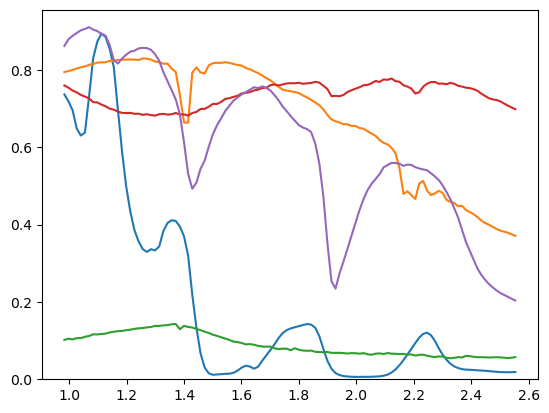

In [177]:
# Get the spectras as the centroids of the clusturs created by KMeans
kmean = KMeans(n_clusters=p)
kmean.fit(endmembers_list.reshape(-1, r))

pure = kmean.cluster_centers_

for k in range(p):
    plt.plot(wavelengths, pure[k])
plt.ylim(bottom=0)

In [178]:
# Get corresponding abundance vectors from SunSal algorithm
endmembers_abund = sunsal(pure.T, endmembers_list.reshape(-1, r).T, addone=True, positivity=True)[0].T.reshape(samples, -1, 1, p)
endmembers_list = endmembers_list.reshape(samples, p, 1, r)

## Model & Training

In [179]:
# Model initialization
model = eguNetss(r, p, size=(height, width), endmembers_count=p)
model.initModel()
model.compileModel(lr=5e-4)
model.model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 i_p (InputLayer)               [(None, 5, 1, 113)]  0           []                               
                                                                                                  
 i_m (InputLayer)               [(None, 128, 128, 1  0           []                               
                                13)]                                                              
                                                                                                  
 L1_C_p (Conv2D)                (None, 5, 1, 128)    14592       ['i_p[0][0]']                    
                                                                                                  
 L1_C_m (Conv2D)                (None, 128, 128, 12  361728      ['i_m[0][0]']              

In [180]:
def take_all_except_k(X, k):
    return np.concatenate((X[:k], X[k+1:]))

In [181]:
# Model training
history = model.trainModel(
    take_all_except_k(endmembers_list, k_test),
    take_all_except_k(endmembers_abund, k_test),
    take_all_except_k(Y_list, k_test),
    batch_size=2,
    epochs=200,
)

h = {}
for key in history.history:
    h[key] = np.array(history.history[key])
h.keys()

Epoch 1/200
15/15 [==============================] - 40s 2s/step - loss: 4.7673 - abundances_pure_loss: 1.5709 - mixed_loss: 0.0353 - abundances_pure_accuracy: 0.3310 - mixed_accuracy: 0.0496 - val_loss: 3.8124 - val_abundances_pure_loss: 1.0455 - val_mixed_loss: 0.0268 - val_abundances_pure_accuracy: 0.9600 - val_mixed_accuracy: 0.0325
Epoch 2/200
15/15 [==============================] - 18s 1s/step - loss: 3.9915 - abundances_pure_loss: 1.1012 - mixed_loss: 0.0295 - abundances_pure_accuracy: 0.8000 - mixed_accuracy: 0.0367 - val_loss: 3.5509 - val_abundances_pure_loss: 0.8890 - val_mixed_loss: 0.0252 - val_abundances_pure_accuracy: 1.0000 - val_mixed_accuracy: 0.1036
Epoch 3/200
15/15 [==============================] - 18s 1s/step - loss: 3.6762 - abundances_pure_loss: 0.9484 - mixed_loss: 0.0267 - abundances_pure_accuracy: 0.9172 - mixed_accuracy: 0.1128 - val_loss: 3.4071 - val_abundances_pure_loss: 0.8353 - val_mixed_loss: 0.0239 - val_abundances_pure_accuracy: 1.0000 - val_mixed_

dict_keys(['loss', 'abundances_pure_loss', 'mixed_loss', 'abundances_pure_accuracy', 'mixed_accuracy', 'val_loss', 'val_abundances_pure_loss', 'val_mixed_loss', 'val_abundances_pure_accuracy', 'val_mixed_accuracy'])

### Training Graphs

(0.0, 4.999550081975758)

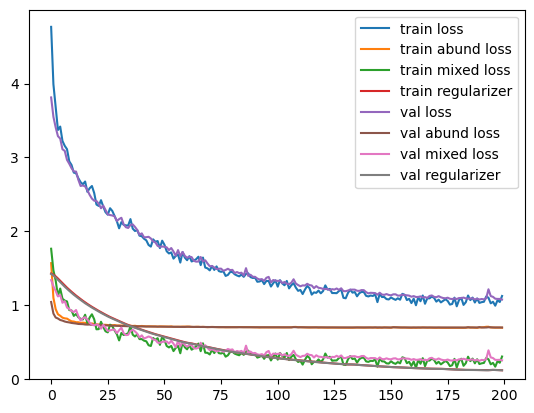

In [182]:
plt.plot(history.epoch, h["loss"], label="train loss")
plt.plot(history.epoch, h["abundances_pure_loss"], label="train abund loss")
plt.plot(history.epoch, h["mixed_loss"]*50, label="train mixed loss")
plt.plot(history.epoch, h["loss"] - h["mixed_loss"] * 50 - h["abundances_pure_loss"], label="train regularizer")
plt.plot(history.epoch, h["val_loss"], label="val loss")
plt.plot(history.epoch, h["val_abundances_pure_loss"], label="val abund loss")
plt.plot(history.epoch, h["val_mixed_loss"]*50, label="val mixed loss")
plt.plot(history.epoch, h["val_loss"] - h["val_mixed_loss"] * 50 - h["val_abundances_pure_loss"], label="val regularizer")
plt.legend()
plt.ylim(bottom=0)

(0.0, 4.999531173985451)

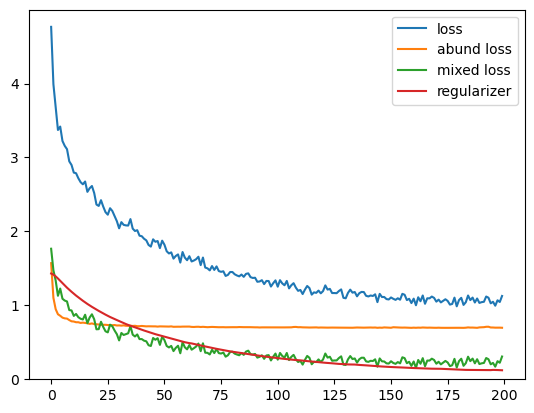

In [183]:
plt.plot(history.epoch, h["loss"], label="loss")
plt.plot(history.epoch, h["abundances_pure_loss"], label="abund loss")
plt.plot(history.epoch, h["mixed_loss"]*50, label="mixed loss")
plt.plot(history.epoch, h["loss"] - h["mixed_loss"] * 50 - h["abundances_pure_loss"], label="regularizer")
plt.legend()
plt.ylim(bottom=0)

(0.0, 3.996988667733967)

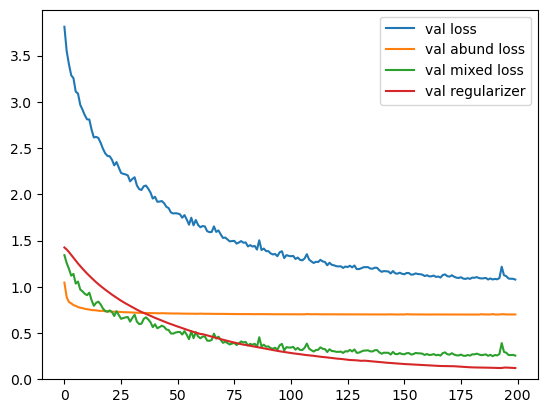

In [184]:
plt.plot(history.epoch, h["val_loss"], label="val loss")
plt.plot(history.epoch, h["val_abundances_pure_loss"], label="val abund loss")
plt.plot(history.epoch, h["val_mixed_loss"]*50, label="val mixed loss")
plt.plot(history.epoch, h["val_loss"] - h["val_mixed_loss"] * 50 - h["val_abundances_pure_loss"], label="val regularizer")
plt.legend()
plt.ylim(bottom=0)

(0.0, 4.956272742152214)

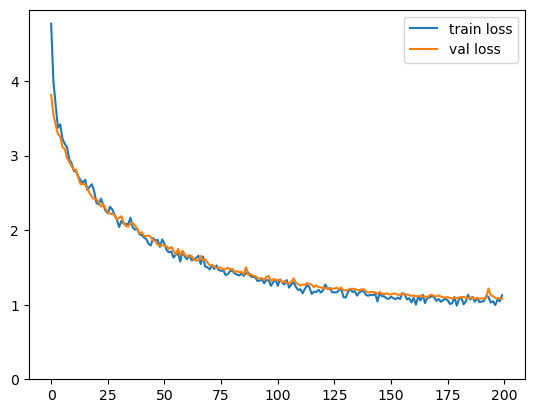

In [185]:
plt.plot(history.epoch, h["loss"], label="train loss")
plt.plot(history.epoch, h["val_loss"], label="val loss")
plt.legend()
plt.ylim(bottom=0)

## Predictions

In [ ]:
X_pred = model.model.predict({"i_p": np.array([endmembers_list[k_test]]), "i_m": np.array([Y_list[k_test]])})
# fig, axes = plt.subplots(nrows=2, ncols=3)


1/1 [==============================] - 0s 199ms/step


(1, 128, 128, 5)

1/1 [==============================] - 1s 633ms/step


<Figure size 640x480 with 0 Axes>

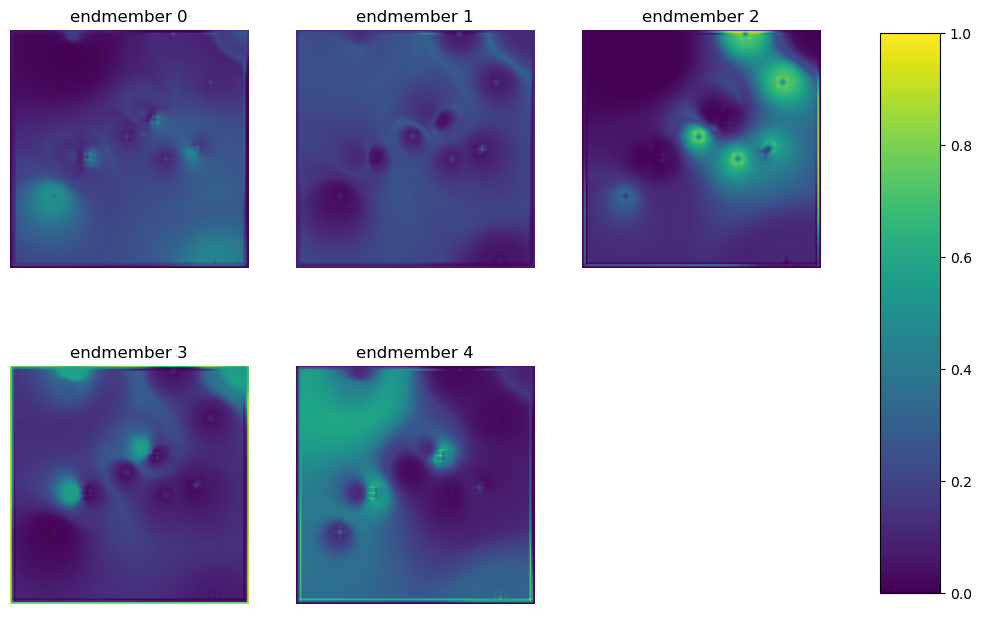

In [193]:
X_pred = model.model.predict({"i_p": np.array([endmembers_list[k_test]]), "i_m": np.array([Y_list[k_test]])})[1][0]

# plot abundances
plt.figure()
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

for k in range(np.prod(axes.shape)):
    ax = axes.flat[k]
    ax.axis("off")
    ax.get_yaxis().set_visible(False)
    if k >= p:
        continue
    ax.set_title(f"endmember {k}")
    im = ax.imshow(X_pred[:, :, k], vmin=0, vmax=1)

fig.subplots_adjust(right=0.8) 
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

# One HSI strategy

In [165]:
X = X_list[k_test]
Y = Y_list[k_test]

## Pre-process

KMeans for the whole image is applied to 16x16 patches of this image

c:\Users\arthu\anaconda3\envs\troisneuf\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


(0.027139646333992504, 0.7938154426692349)

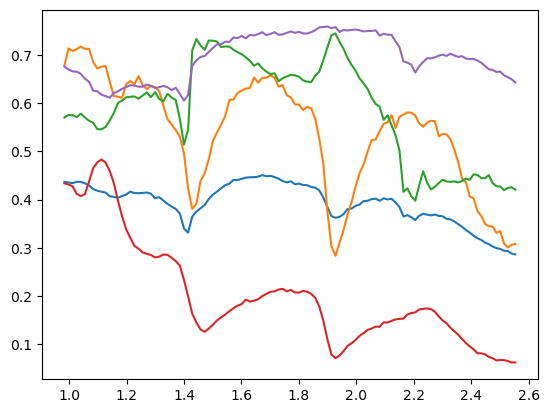

In [166]:
# Patches from the whole image
patch_size = 16

patches, patch_key = getPatches(Y, patch_size)

# VCA applied to each patch
n_pure_per_patch = 2
endmembers = np.zeros((n_pure_per_patch * len(patches), r))

for k in range(len(patches)):
    patch = patches[k]
    endmembers[k*n_pure_per_patch: (k+1)*n_pure_per_patch] = vca(patch.reshape((-1, r)).T, n_pure_per_patch, verbose=False)[0].T

# get endmembers spectra (centroids of the clusters) with Kmeans
n_pure = p #Usually we need to find it with the elbow method
kmean = KMeans(n_clusters=n_pure)
kmean.fit(endmembers)
pure = kmean.cluster_centers_

size = patches[0].shape[:2]
endmember_count = n_pure_per_patch

for k in range(p):
    plt.plot(wavelengths, pure[k])
plt.ylim()

Do not really work well so we do VCA on the whole image to get the endmembers spectra. After we'll use them for SUNSAL.

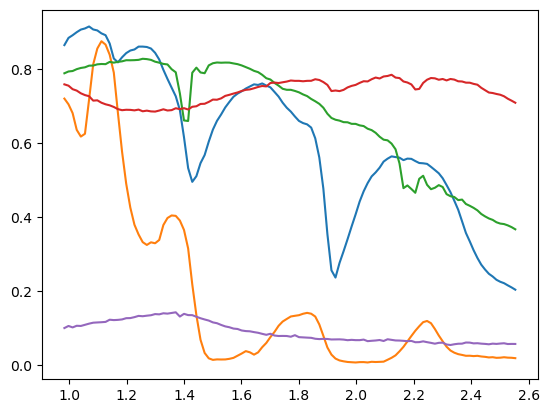

In [167]:
pure = vca(Y.reshape(-1, r).T, p, verbose=False)[0].T
for k in range(p):
    plt.plot(wavelengths, pure[k])

In [168]:
# Get abund of each vca of each patch with SUNSAL
endmembers_abund = sunsal(pure.T, endmembers.T, addone=True, positivity=True)[0].T

endmembers_abund = endmembers_abund.reshape((-1, n_pure_per_patch, 1, n_pure))
endmembers = endmembers.reshape((-1, n_pure_per_patch, 1, r))

## Patch strategy

In [145]:
k_test = np.random.randint(0,len(patches))

model = eguNetss(r, p, size=size, endmembers_count=endmember_count)
model.initModel()
model.compileModel(lr=1e-4)
history = model.trainModel(
    endmembers, 
    endmembers_abund, 
    patches,
    batch_size=2, 
    epochs=100
)
h = {}
for key in history.history:
    h[key] = np.array(history.history[key])

Epoch 1/100
30/30 [==============================] - 5s 124ms/step - loss: 6.0820 - abundances_pure_loss: 1.9335 - mixed_loss: 0.0544 - abundances_pure_accuracy: 0.1833 - mixed_accuracy: 0.0431 - val_loss: 5.6228 - val_abundances_pure_loss: 1.8245 - val_mixed_loss: 0.0474 - val_abundances_pure_accuracy: 0.2000 - val_mixed_accuracy: 0.0362
Epoch 2/100
30/30 [==============================] - 5s 155ms/step - loss: 5.3429 - abundances_pure_loss: 1.7791 - mixed_loss: 0.0428 - abundances_pure_accuracy: 0.1583 - mixed_accuracy: 0.0542 - val_loss: 5.2984 - val_abundances_pure_loss: 1.7246 - val_mixed_loss: 0.0431 - val_abundances_pure_accuracy: 0.2500 - val_mixed_accuracy: 0.0459
Epoch 3/100
30/30 [==============================] - 3s 107ms/step - loss: 5.2667 - abundances_pure_loss: 1.7194 - mixed_loss: 0.0427 - abundances_pure_accuracy: 0.2417 - mixed_accuracy: 0.0579 - val_loss: 5.1280 - val_abundances_pure_loss: 1.6604 - val_mixed_loss: 0.0412 - val_abundances_pure_accuracy: 0.3375 - val_

(0.0, 6.348438962921501)

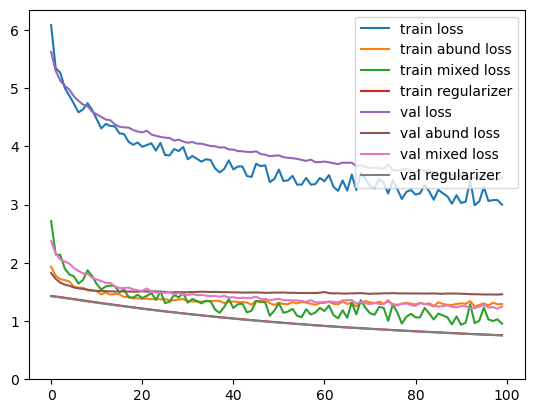

In [146]:
plt.plot(history.epoch, h["loss"], label="train loss")
plt.plot(history.epoch, h["abundances_pure_loss"], label="train abund loss")
plt.plot(history.epoch, h["mixed_loss"]*50, label="train mixed loss")
plt.plot(history.epoch, h["loss"] - h["mixed_loss"] * 50 - h["abundances_pure_loss"], label="train regularizer")
# plt.plot(history.epoch, history.history["abundances_pure_accuracy"], label="train")
# plt.plot(history.epoch, history.history["val_abundances_pure_accuracy"], label="val")
plt.plot(history.epoch, h["val_loss"], label="val loss")
plt.plot(history.epoch, h["val_abundances_pure_loss"], label="val abund loss")
plt.plot(history.epoch, h["val_mixed_loss"]*50, label="val mixed loss")
plt.plot(history.epoch, h["val_loss"] - h["val_mixed_loss"] * 50 - h["val_abundances_pure_loss"], label="val regularizer")
plt.legend()
plt.ylim(bottom=0)

4/4 [==============================] - 0s 48ms/step


<Figure size 640x480 with 0 Axes>

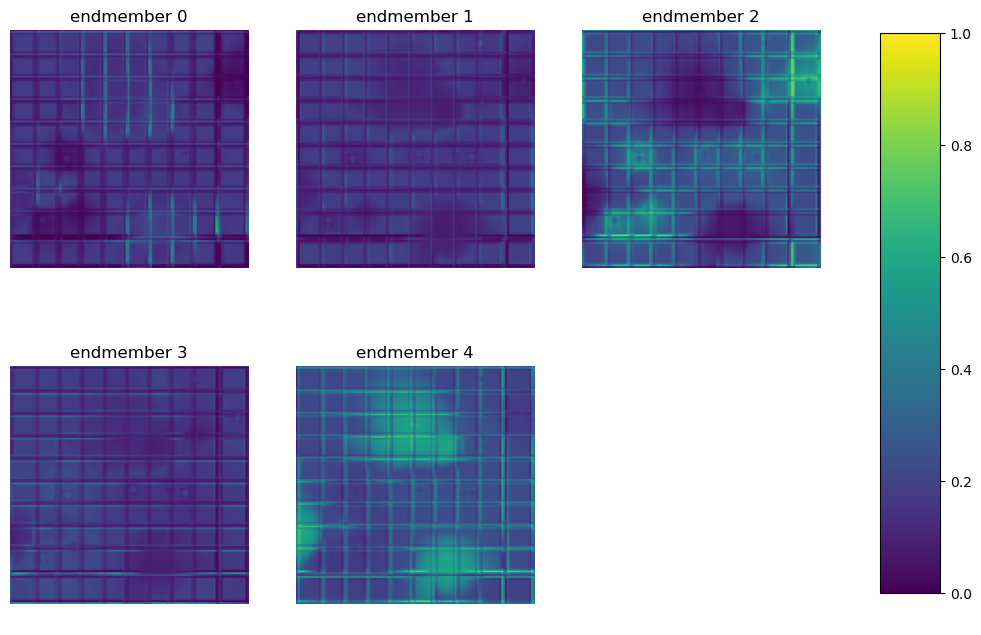

In [149]:
predict = model.model.predict(
    {"i_p": endmembers, "i_m": patches}
)
X_pred = getImageFromPatches(predict[1], patch_key)

plt.figure()
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

for k in range(np.prod(axes.shape)):
    ax = axes.flat[k]
    ax.axis("off")
    ax.get_yaxis().set_visible(False)
    if k >= p:
        continue
    ax.set_title(f"endmember {k}")
    im = ax.imshow(X_pred[:, :, k], vmin=0, vmax=1)

fig.subplots_adjust(right=0.8) 
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

## Whole image 

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 6.7107 - abundances_pure_loss: 1.9350 - mixed_loss: 0.0668 - abundances_pure_accuracy: 0.2500 - mixed_accuracy: 0.0104
Epoch 2/100
1/1 [==============================] - 1s 579ms/step - loss: 6.4996 - abundances_pure_loss: 1.9388 - mixed_loss: 0.0625 - abundances_pure_accuracy: 0.2350 - mixed_accuracy: 0.0099
Epoch 3/100
1/1 [==============================] - 1s 532ms/step - loss: 6.1576 - abundances_pure_loss: 1.9476 - mixed_loss: 0.0555 - abundances_pure_accuracy: 0.2000 - mixed_accuracy: 0.0071
Epoch 4/100
1/1 [==============================] - 1s 589ms/step - loss: 5.8217 - abundances_pure_loss: 1.9152 - mixed_loss: 0.0495 - abundances_pure_accuracy: 0.2350 - mixed_accuracy: 0.0088
Epoch 5/100
1/1 [==============================] - 1s 686ms/step - loss: 5.5454 - abundances_pure_loss: 1.9343 - mixed_loss: 0.0436 - abundances_pure_accuracy: 0.2400 - mixed_accuracy: 0.0121
Epoch 6/100
1/1 [==========================

(0.0, 7.020285232737661)

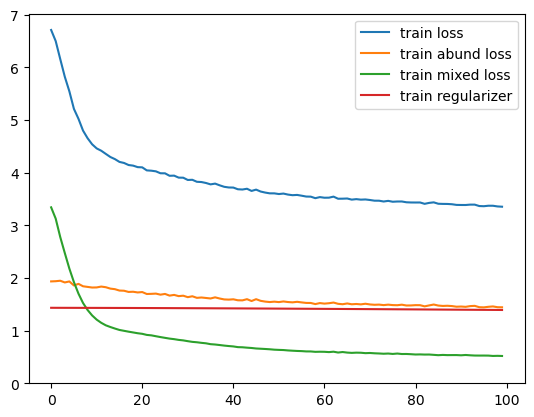

In [171]:
# reshape to accept the whole image
endmembers_abund_whole = endmembers_abund.reshape((1, -1, 1, p))
endmembers_whole = endmembers.reshape((1, -1, 1, r))

size = Y.shape[:2]
endmember_count = endmembers_whole.shape[1]

Y_whole = Y.reshape((1, Y.shape[0], Y.shape[1], Y.shape[2]))

# model init and training
model = eguNetss(r, p, size=size, endmembers_count=endmember_count)
model.initModel()
model.compileModel(lr=1e-4)
history = model.trainModel(endmembers_whole, endmembers_abund_whole, Y_whole, batch_size=1, epochs=100, validation_split=0)
h = {}
for key in history.history:
    h[key] = np.array(history.history[key])
    
# losses plot
plt.plot(history.epoch, h["loss"], label="train loss")
plt.plot(history.epoch, h["abundances_pure_loss"], label="train abund loss")
plt.plot(history.epoch, h["mixed_loss"]*50, label="train mixed loss")
plt.plot(history.epoch, h["loss"] - h["mixed_loss"] * 50 - h["abundances_pure_loss"], label="train regularizer")
plt.legend()
plt.ylim(bottom=0)

1/1 [==============================] - 1s 581ms/step


<Figure size 640x480 with 0 Axes>

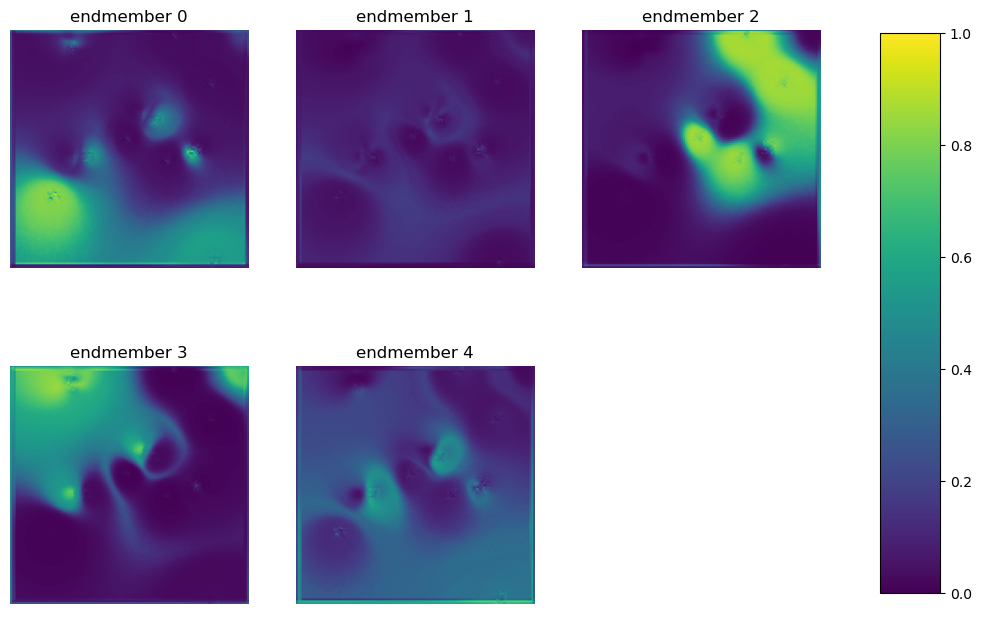

In [174]:
# predict
predict = model.model.predict(
    {"i_p": endmembers_whole, "i_m": Y_whole}
)
X_pred = predict[1][0]

# plot abundances
plt.figure()
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

for k in range(np.prod(axes.shape)):
    ax = axes.flat[k]
    ax.axis("off")
    ax.get_yaxis().set_visible(False)
    if k >= p:
        continue
    ax.set_title(f"endmember {k}")
    im = ax.imshow(X_pred[:, :, k], vmin=0, vmax=1)

fig.subplots_adjust(right=0.8) 
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()